In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -ptorch,pandas,numpy -m

torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, get_rnn_classifier, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu, LanguageModelLoader, LanguageModelData
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from fastai.text import accuracy
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sentencepiece as spm

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_bpe_douban/")
path.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [9]:
df_ratings = pd.read_csv("../data/ratings_word.csv")
df_ratings.head()

,comment,rating
0,别 拿 矫揉造作 的 资产阶级 情调 麻醉 中国 人民 ！,1
1,文青 们 向往 的 生活 ， 可是 生活 中 没有 了 喜怒哀乐 ， 没有 了 问题 与 冲...,2
2,自由 也许 在 大理 ， 生活 确实 在 别处 。,3
3,原来 八旬 是 小四 的 老公 ， 小 彩旗 的 爹 ， 杨丽萍 的 妹夫 。,3
4,关于 大理 的 蓝光 旅游 宣传片 。,3


In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

### Use the BPE Vocabulary from the Wiki model

In [7]:
UNK = 0
BEG = 1
EMB_DIM = 300

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/bpe_model.model")

True

#### Tokenize

In [11]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))

In [12]:
assert len(tokens_train) == df_train.shape[0]

In [14]:
tokens_train[0]

array([   1,   17,  265,  226, 3354,   28,  603,  956, 5043,    3,  410,   11,  218, 2900,  133,   17, 4569,
       5471,  381,    5,  133, 1670,   12,   68, 3781, 4228, 6047,    4, 4569, 6521,    3, 2937, 2376,   29,
         17,   15,    3,   40, 4452,  198,  265,   15, 1226,    5])

#### Embedding
We can keep using the original embedding matrix, but the row corresponding to the BEG token must be zeroed.

In [17]:
MODEL_PATH = "../data/cache/lm_bpe/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([7500, 300])

In [18]:
weights['0.encoder.weight'][BEG, :] = 0
weights['0.encoder_with_dropout.embed.weight'][BEG, :] = 0
weights['1.decoder.weight'][BEG, :] = 0

In [22]:
n_toks = weights['0.encoder.weight'].shape[0]

### (TODO) Use the Refitted Vocabulary

In [ ]:
itos_orig = []
with open("data/bpe_model.vocab") as f:
    for line in f.readlines():
        itos_orig.append(line.split("\t"))
itos = []
with open("data/rating_bpe_model.vocab") as f:
    for line in f.readlines():
        itos.append(line.split("\t"))
n_toks = len(itos)

In [ ]:
mapping = {s: idx for idx, s in enumerate(itos)}
mapping_orig = {s: idx for idx, s in enumerate(itos_orig)}

In [144]:
voc_diff = set(itos) - set(itos_orig)
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:50]

[('撞车', 6712),
 ('荡气回肠', 6711),
 ('跳脱', 6708),
 ('完成度', 6707),
 ('慌', 6706),
 ('孰', 6701),
 ('情色片', 6697),
 ('6.', 6695),
 ('膜拜', 6692),
 ('不可否认', 6691),
 ('尔冬', 6690),
 ('帕索里尼', 6689),
 ('浴室', 6688),
 ('华生', 6687),
 ('影坛', 6685),
 ('钢铁侠', 6684),
 ('政治片', 6682),
 ('少爷', 6681),
 ('戴安娜', 6680),
 ('落魄', 6678),
 ('霓虹', 6676),
 ('眼花缭乱', 6674),
 ('闷片', 6672),
 ('巴赫', 6671),
 ('拧', 6667),
 ('理所当然', 6666),
 ('凄凉', 6665),
 ('表象', 6662),
 ('坚信', 6661),
 ('硬生生', 6660),
 ('徘徊', 6658),
 ('力气', 6657),
 ('李政宰', 6656),
 ('吴君如', 6655),
 ('朱茵', 6654),
 ('梁咏琪', 6653),
 ('林熙蕾', 6652),
 ('骨', 6651),
 ('波兰斯基', 6650),
 ('分量', 6647),
 ('试试', 6645),
 ('贫民窟', 6644),
 ('老人家', 6643),
 ('满屏', 6642),
 ('来看', 6641),
 ('光鲜', 6639),
 ('跨度', 6637),
 ('挺烂', 6632),
 ('虐杀', 6631),
 ('难得一见', 6629)]

#### Tokenize

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/rating_bpe_model.model")

In [15]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))
assert len(tokens_train) == df_train.shape[0]        

In [74]:
tokens_val[0]

array([  1, 198, 137,  90,   2])

In [75]:
df_val.iloc[0]

comment    男 主角 像 卡卡
rating             2
label              0
Name: 681247, dtype: object

#### Prepare the embedding matrix

In [17]:
MODEL_PATH = "../data/cache/lm_bpe/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([9697, 300])

In [18]:
new_matrix = np.zeros((n_toks, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.encoder.weight'][mapping_orig[w]]
        hits += 1
new_matrix[BEG, :] = 0
hits, hits *100 / len(itos[3:])

(3851, 57.39195230998509)

In [19]:
weights['0.encoder.weight'] = T(new_matrix)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_matrix))
weights['1.decoder.weight'] = T(np.copy(new_matrix))

## Languange Model

In [19]:
bs = 64
bptt = 50
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt)

In [20]:
np.max(np.array(list(itertools.chain.from_iterable(tokens_train))))

7499

In [23]:
model_data = LanguageModelData(path, pad_idx=2, n_toks, trn_dl, val_dl, bs=bs, bptt=bptt)

In [25]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))

In [26]:
learner = model_data.get_model(opt_fn, EMB_DIM, 500, 3, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [27]:
learner.model.load_state_dict(weights)

In [28]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=1e-7, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.887072   4.642742   0.220762  



[4.642741552534094, 0.22076220693974255]

In [29]:
learner.save('lm_last_ft')

In [29]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.640776   4.467984   0.243411  



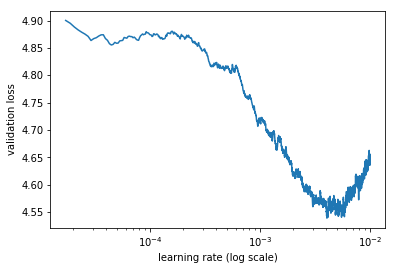

In [30]:
learner.sched.plot()

In [31]:
lr = 3e-3
lrs = lr
learner.fit(lrs, 1, wds=1e-7, use_clr=(20,5), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      4.458798   4.258573   0.263162  
    1      4.377989   4.196744   0.270516                     
    2      4.323022   4.141575   0.277041                     
    3      4.275778   4.103361   0.281353                     
    4      4.234403   4.072433   0.285147                     
    5      4.1906     4.045657   0.288378                     
    6      4.17791    4.02293    0.290767                     
    7      4.159768   4.001841   0.293308                     
    8      4.128199   3.985417   0.295357                     
    9      4.117134   3.972484   0.297013                     



[3.972484000491414, 0.29701312183116135]

In [32]:
learner.save_encoder("lm1_enc")

In [33]:
learner.save("lm1")

In [34]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

### Full Dataset (v1)

In [35]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [36]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [57]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [58]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [59]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=2,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [60]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 81%|████████  | 13381/16520 [02:41<00:37, 82.68it/s, loss=3.43] 

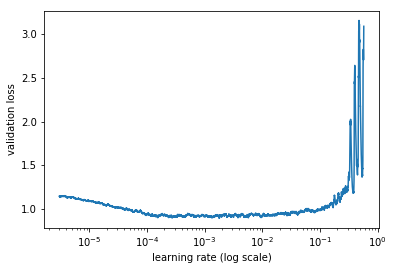

In [41]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [61]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.856228   0.832476   0.605154  


[0.8324762385991055, 0.605154136021066]

In [62]:
learn.save('clas_0')

In [63]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.899033   0.82525    0.608905  


[0.8252498766094984, 0.6089053845455371]

In [64]:
learn.save('clas_1')

In [65]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.876308   0.819594   0.612117  
    1      0.840688   0.802949   0.623899                        
    2      0.832754   0.794423   0.628286                        
    3      0.82092    0.785761   0.633666                        
    4      0.831765   0.782842   0.634977                        
    5      0.809403   0.778328   0.636884                        
    6      0.805607   0.778388   0.637684                        
    7      0.786681   0.772783   0.640397                        
    8      0.801923   0.771937   0.640493                        
    9      0.786408   0.771732   0.640289                        
    10     0.822331   0.768929   0.641322                        
    11     0.813187   0.767903   0.642633                        
    12     0.799268   0.769283   0.64152                         
    13     0.808133   0.768119   0.641713                        


[0.7681186105719403, 0.6417132025787705]

In [66]:
learn.save("clas_full")

#### Evaluate

In [67]:
learn.load("clas_full")
learn.model.reset()
_ = learn.model.eval()

In [68]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [69]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [70]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [71]:
pd.Series(preds).value_counts()

2    95602
1    49825
0    30781
dtype: int64

In [72]:
np.sum(ys==preds) / ys.shape[0]

0.6417132025787705

In [73]:
np.where(ys==0)

(array([    11,     17,     20, ..., 176186, 176202, 176205]),)

In [77]:
tokens_val[176196]

array([   1, 1781,    4, 4429, 6548,    3,  165, 5024,  213,   44,   95, 1851, 4750,   12,    3,   19, 2054,
       4569, 6935])

In [76]:
sp.DecodeIds(tokens_val[176196].tolist()), df_val["comment"].iloc[176196]

('如此 的 欺骗 , 或许 我 也 就 释然 了 , 有 什么 呢', '如此 的 欺骗 ， 或许 我 也 就 释然 了 ， 有 什么 呢')

In [79]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [80]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

array([[ 0.60352,  0.39514, -0.37776]], dtype=float32)

In [81]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

array([[-2.78679, -1.59306,  2.252  ]], dtype=float32)

In [82]:
get_prediction("说 实话 我 没 怎么 认真 看 ， 电影院 里 的 熊 孩子 太 闹腾 了 ， 前面 的 小奶娃 还 时不时 站 "
               "在 老爸 腿上 蹦迪 ， 观影 体验 极差 ， 不过 小朋友 应该 挺 喜欢 的")

array([[-0.79044,  0.54242, -0.16996]], dtype=float32)

In [83]:
get_prediction("这 电影 太 好笑 了 ， 说好 的 高科技 人才 研制 的 产品 永远 在 关键 时候 失灵 "
               "； 特地 飞 到 泰国 请来 救援 人才 ， 大家 研究 出 的 方法 每次 都是 先 给 鲨鱼 "
               "当 诱饵 … … 显然 这样 的 对战 坚持不了 多久 ， 只能 赶紧 让 鲨鱼 输 了 。")

array([[-1.96362, -0.11075,  1.62943]], dtype=float32)

In [84]:
get_prediction("太 接地气 了 ， 在 三亚 煮饺子 式 的 景区 海域 ， 冒出来 一条 大 鲨鱼 "
               "… … 爽点 也 很 密集 ， 郭达森 与 李冰冰 的 CP 感 不错 ， 编剧 果然 是 "
               "老外 ， 中文 台词 有点 尬 。")

array([[-0.31751,  0.77071, -0.397  ]], dtype=float32)

In [85]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

array([[-0.04668,  0.45921, -0.20217]], dtype=float32)

In [86]:
get_prediction("太 难 了 。 。 。")

array([[ 0.47348, -0.56913, -0.39871]], dtype=float32)

In [87]:
get_prediction("把 我 基神 写成 智障 ， 辣鸡 mcu")

array([[ 0.91502, -0.03212, -0.18764]], dtype=float32)

In [88]:
get_prediction("鲨鱼 部分 还是 不错 的 ， 尤其 是 中段 第一次 出海 捕鲨 非常 刺激 ， 其后 急速 下滑 ， "
               "三亚 那 部分 拍得 是什么 鬼 。 。 。 爆米花 片 可以 适度 的 蠢 ， 但 人类 反派 炸鲨 "
               "和 直升机 相撞 部分 简直 蠢得 太过份 了 吧 ？ 另外 充满 硬 加戏 视感 的 尴尬 感情戏 "
               "把 节奏 也 拖垮 了 ， 明明 可以 更 出色 ， 却 很遗憾 地 止步 在 马马虎虎 的 水平 。 6 / 10")

array([[-0.08641,  1.14758, -1.64688]], dtype=float32)

In [89]:
get_prediction("老冰冰 真的 很努力 ！ 为 老冰冰 实现 了 她 的 好莱坞 女主梦 鼓掌 . . .")

array([[-1.55302,  0.33905,  0.67304]], dtype=float32)

In [90]:
get_prediction("结局 简直 丧 出 天际 ！ 灭霸 竟然 有 内心戏 ！ 全程 下来 美队 "
               "和 钢铁侠 也 没 见上 一面 ， 我 还 以为 在 世界 末日 前 必然 "
               "要 重修 旧好 了 ！ ")

array([[-0.19799,  0.02715,  0.28132]], dtype=float32)

In [91]:
get_prediction("太 烂 了 ， 难看 至极 。")

array([[ 3.69365, -1.72381, -1.55847]], dtype=float32)

In [92]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

array([[ 1.47285,  0.39211, -1.60118]], dtype=float32)

In [93]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

array([[-0.23274,  0.4654 ,  0.03084]], dtype=float32)

In [94]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

array([[-0.18053, -0.31528,  0.29775]], dtype=float32)

In [95]:
get_prediction("还 我 电影票 14 元")

array([[ 0.54269,  0.00009, -0.59087]], dtype=float32)

Confusion matrix, without normalization
[[19687  9534  5582]
 [ 8168 28287 24919]
 [ 2926 12004 65101]]


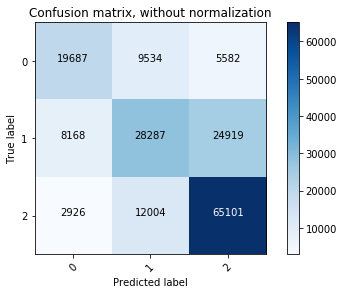

In [96]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.57 0.27 0.16]
 [0.13 0.46 0.41]
 [0.04 0.15 0.81]]


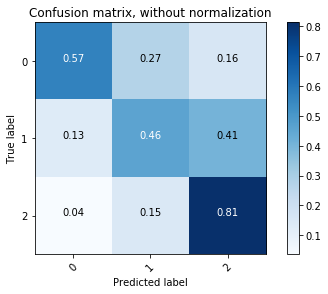

In [97]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [98]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 64%, R 57%, FS 0.60, Support: 34803
Class 1: P 57%, R 46%, FS 0.51, Support: 61374
Class 2: P 68%, R 81%, FS 0.74, Support: 80031


In [99]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [100]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [101]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [102]:
np.sum(ys==preds) / ys.shape[0]

0.6408469487937619

Confusion matrix, without normalization
[[19398  9688  5716]
 [ 8205 28494 24676]
 [ 2925 12076 65031]]


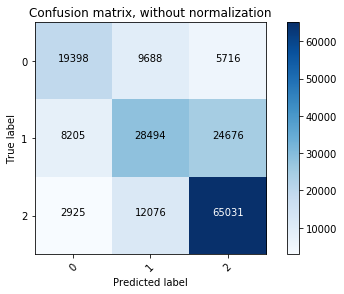

In [103]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.56 0.28 0.16]
 [0.13 0.46 0.4 ]
 [0.04 0.15 0.81]]


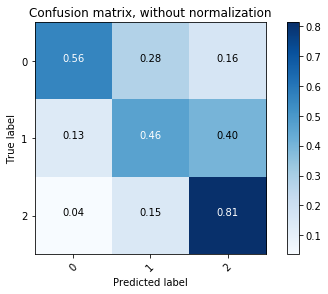

In [104]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [105]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 64%, R 56%, FS 0.59, Support: 34802
Class 1: P 57%, R 46%, FS 0.51, Support: 61375
Class 2: P 68%, R 81%, FS 0.74, Support: 80032


### Smaller Dataset 

In [106]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [107]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [108]:
np.array(df_train_small.index)

array([382034, 508534, 316814, ..., 379280, 260647, 388817])

In [109]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [110]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [111]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [112]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 82%|████████▏ | 1151/1407 [00:11<00:02, 103.14it/s, loss=3.87]

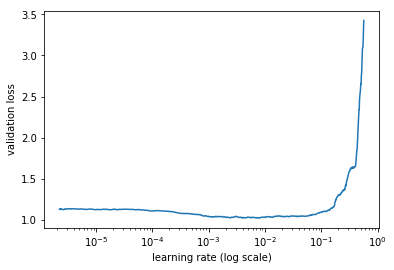

In [113]:
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [114]:
lr=1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.016628   0.930461   0.546733  


[0.9304610318183899, 0.5467333333651225]

In [115]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.997051   0.919488   0.557267  


[0.9194877066612244, 0.5572666666666667]

In [116]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.996907   0.90901    0.560933  
    1      0.983014   0.89124    0.575133                      
    2      0.950906   0.884902   0.575867                      
    3      0.956739   0.877001   0.577867                      
    4      0.959864   0.874492   0.5862                        
    5      0.933367   0.87016    0.586867                      
    6      0.941742   0.865012   0.590467                      
    7      0.92865    0.863915   0.591467                      
    8      0.925976   0.860311   0.5924                        
    9      0.95384    0.862567   0.5928                        
    10     0.929194   0.859637   0.592333                      
    11     0.918328   0.856708   0.594333                      
    12     0.936586   0.859992   0.592733                      
    13     0.897562   0.856533   0.594133                      


[0.8565332041104634, 0.5941333333969117]

In [117]:
learn.save("clas_small_full")

In [118]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [119]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.68 0.2  0.11]
 [0.26 0.42 0.32]
 [0.11 0.2  0.68]]


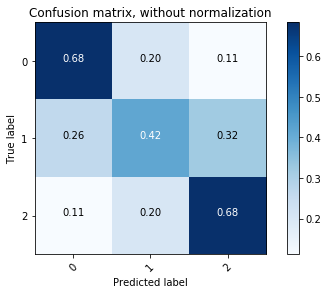

In [120]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [121]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [122]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [123]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [124]:
np.sum(preds==ys) / preds.shape[0]

0.5897655624854576

Normalized confusion matrix
[[0.66 0.21 0.12]
 [0.26 0.42 0.32]
 [0.11 0.2  0.69]]


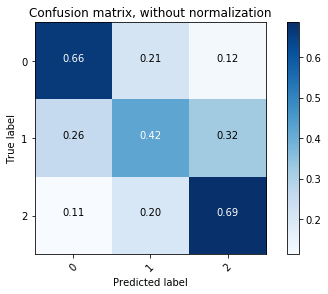

In [125]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [126]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 48%, R 66%, FS 0.56, Support: 34802
Class 1: P 52%, R 42%, FS 0.47, Support: 61375
Class 2: P 70%, R 69%, FS 0.69, Support: 80032


## Regressor

In [127]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [128]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [129]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 1], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [130]:
class RNN_RegLearner(RNN_Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [131]:
learn = RNN_RegLearner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = []
learn.load_encoder('lm1_enc')

In [134]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

 80%|████████  | 13250/16520 [02:47<00:41, 79.30it/s, loss=3.52] 

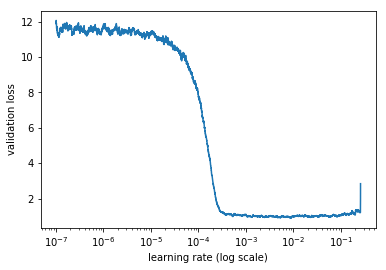

In [133]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [135]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                   
    0      0.947309   0.826133  


In [136]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.863943   0.796839  


In [137]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.881277   0.774157  
    1      0.891325   0.744809                                   
    2      0.843736   0.725885                                   
    3      0.797029   0.713527                                   
    4      0.787337   0.711382                                   
    5      0.752415   0.710653                                   
    6      0.757807   0.697433                                   
    7      0.770657   0.691492                                   
    8      0.752695   0.688612                                   
    9      0.711472   0.688091                                   
    10     0.769668   0.686148                                   
    11     0.747323   0.686398                                   
    12     0.762411   0.683425                                   
    13     0.730976   0.684514                                   


In [138]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [139]:
learn.load('reg_full')

### Evaluation

In [140]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [141]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [142]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [143]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [144]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6845143151133887

In [145]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.682066214005607

In [146]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,label,preds
0,男 主角 像 卡卡,2,0,3.579664
1,经典 改编 ， 还是 忠于 原著 的 ， 一路 都 很 稳 。,4,2,3.988468
2,叙事 ： 时间 空间 的 有机 结合,5,2,3.996587
3,看 街头 小 混混 打 外星人 挺 热闹 的 ， 可是 前 一 秒 还 在 抢劫 的 少年犯...,2,0,2.612373
4,这 电影 也 就 一般,3,1,2.747960


In [147]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.6820661310378101

In [148]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [149]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6878147626187742

In [150]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说 .,3,1,2.863086
118491,老师 你 太 可爱,5,2,4.171313
44768,说 了 好多 话 ， 可惜 都 是 陈词滥调 、 无 凭 无据 。,2,0,2.539259
34630,普巴 家用 的 电脑 是 苹果 。,3,1,3.526885
382761,这 才 是 一 部 看 完 之后 观众 讲 不 清道 不 明 的 电影 ， 主线 不 明了 ...,4,2,3.181901


In [151]:
df_test.sample(20)

,comment,rating,label,preds
139851,加 一 星 给 meg,4,2,3.891860
830654,泰迪罗宾 很 有 才华 .,5,2,4.073572
592899,这 是 情欲片 么 ... 啪啪啪 的 镜头 真是 够长 ， 身材 倒是 不错 ...,2,0,2.787393
316197,轻松 愉快 ， 我 喜欢 的 类型 ， 世妍 妹 纸 好评 ~,4,2,4.185055
602217,中国 电影 资料馆 ， 过冬 好 去处 ， 老片 国产 10 块 外片 20 块 一 场 。...,4,2,3.347950
95114,非 文艺 青年 的 我 对 现代 舞真 的 无感 ， 但是 本片 真 的 很 美 ！,4,2,3.960909
268084,有点 失望 ， 看到 这 演员 阵容 ， 以为 会 更 给力 一点 的,2,0,2.869042
634803,俄国 到 今天 还有 “ 平反 ” 一 说 ？ 真是 个 纠结 于 历史 的 令 人 崇敬 ...,3,1,3.891083
346109,一 看 剪辑 就 知道 是 索德博格 电影,4,2,3.471107
142052,钱德尔 的 导演 试水 。 两 条 线索 并行 ， 回忆 和 现实 交织 ， 人物 最终 得...,3,1,2.854237


In [152]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.6878147626187741

In [153]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 2003  4541  3992   940    46]
 [  865  7461 12328  2600    26]
 [  164  4649 35699 20616   247]
 [   13   635 15500 36774  1727]
 [   17   229  3596 18042  3499]]


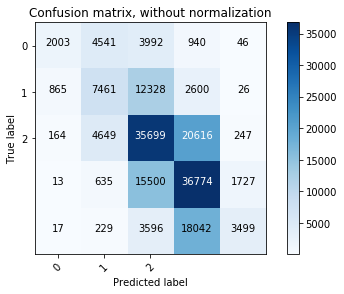

In [154]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [155]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 65%, R 17%, FS 0.27, Support: 11522
Class 1: P 43%, R 32%, FS 0.37, Support: 23280
Class 2: P 50%, R 58%, FS 0.54, Support: 61375
Class 3: P 47%, R 67%, FS 0.55, Support: 54649
Class 4: P 63%, R 14%, FS 0.23, Support: 25383


In [158]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [159]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

2.6324472

In [160]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

4.7572536

In [163]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

3.0530272

In [166]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

2.962475

In [165]:
get_prediction("太 烂 了 ， 难看 至极 。")

1.1703147

In [164]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

2.1972356

In [162]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

3.4935005

In [161]:
get_prediction("还 我 电影票 14 元")

2.576889